In [2]:
import os
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps


In [ ]:
bat_sz = 32
pix_sz = 500
epochs = 30
l_r = 0.0001
val_ratio = 0.2
dataset_path = 'dataset/'
device = torch.device('cpu')

For details check out : [Ova-sense](https://github.com/SoumilB7/Ova-sense)

In [62]:
def augment_image(image):
    if random.random() > 0.5:
        image = ImageOps.mirror(image)
    
    if random.random() > 0.5:
        image = ImageOps.flip(image)
    
    if random.random() > 0.5:
        angle = random.uniform(-20, 20)
        image = image.rotate(angle)

    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.8, 1.2))
        
    return image

In [63]:
class CancerDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.data = []

        for i,clas in enumerate(['negative', 'positive']):
            class_path = os.path.join(path, clas)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.data.append((img_path, i))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        image = image.resize((pix_sz, pix_sz))
        
        image = augment_image(image) # convert the sizes
        
        image = np.array(image).astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) #(H, W, C) → (C, H, W)
        
        return torch.tensor(image), torch.tensor(label, dtype=torch.float32)
        

In [75]:
train_dataset = CancerDataset(dataset_path)
loads = DataLoader(train_dataset, batch_size=bat_sz, shuffle=True)

In [74]:
# CNN 
class CancerDetectionCNN(nn.Module):
    def __init__(self):
        super(CancerDetectionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # in order to send in normalized activations
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (pix_sz // 16) * (pix_sz // 16), 512), 
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 1),  
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x




In [76]:
model = CancerDetectionCNN().to(device)
loss_type = nn.BCELoss() 

optimizer = optim.Adam(model.parameters(), lr=l_r)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


In [ ]:
train_size = int(len(train_dataset) * (1 - val_ratio))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=bat_sz, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=bat_sz, shuffle=False)

model.train()
best_loss = 1000000
val_acc = 0
losses = []
accuracies = []
    
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_type(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_description(f'Epoch [{epoch+1}/{epochs}]')
        loop.set_postfix(loss=loss.item(), acc=correct/total)
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    accuracies.append(epoch_acc)
    losses.append(epoch_loss)

    # Validation step
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)

            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    scheduler.step(epoch_loss)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'model_archives/cancer_detection_model_post.pth')
        print(f"Model saved at epoch {epoch + 1}")

    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}, Val Accuracy = {val_acc:.4f}")
        

Epoch [1/30]: 100%|██████████| 25/25 [03:52<00:00,  9.30s/it, acc=0.795, loss=0.0175]


Model saved at epoch 1
Epoch 1: Loss = 1.1287, Accuracy = 0.7950, Val Accuracy = 0.6700


Epoch [2/30]: 100%|██████████| 25/25 [03:42<00:00,  8.89s/it, acc=0.616, loss=0.873]


Epoch 2: Loss = 1.6025, Accuracy = 0.6162, Val Accuracy = 0.6700


Epoch [3/30]: 100%|██████████| 25/25 [03:17<00:00,  7.91s/it, acc=0.743, loss=0.432]


Model saved at epoch 3
Epoch 3: Loss = 0.5381, Accuracy = 0.7425, Val Accuracy = 0.8900


Epoch [4/30]: 100%|██████████| 25/25 [02:57<00:00,  7.09s/it, acc=0.954, loss=0.116]


Model saved at epoch 4
Epoch 4: Loss = 0.2350, Accuracy = 0.9537, Val Accuracy = 1.0000


Epoch [5/30]:  48%|████▊     | 12/25 [01:30<01:38,  7.55s/it, acc=0.992, loss=0.0452]


KeyboardInterrupt: 

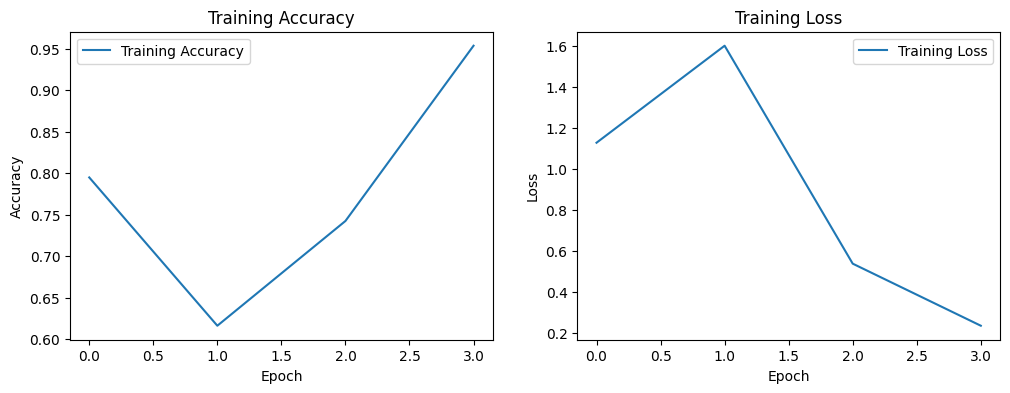

In [78]:
# Accuracy Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
